In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from os.path import exists, join
from marbleri.nwp import BestTrackNetCDF
from marbleri.process import get_hwrf_filenames_diff, get_var_levels, load_hwrf_data_distributed, \
    normalize_hwrf_loaded_data, discretize_output, scaler_classes
from matplotlib.colors import LogNorm
from os import makedirs
from glob import glob
from hagelslag.evaluation.ProbabilityMetrics import DistributedReliability, DistributedROC
from hagelslag.evaluation.MetricPlotter import attributes_diagram, performance_diagram, roc_curve
from marbleri.evaluate import linear_metrics

## HWRF ML Model Evaluation
The goal of this notebook is to generate verification plots from the train_hwrf_ml.py script results. The script outputs a set of csv files with model predictions and summary statistics.

In [2]:
# load yaml config file
def read_config(config_file):
    with open(config_file, "r") as config_obj:
        config = yaml.load(config_obj, Loader=yaml.Loader)
    return config

config_files = {"2019": "/glade/u/home/dgagne/marbleri/config/hwrf_train_2019.yml",
                "2020": "/glade/u/home/dgagne/marbleri/config/hwrf_train_2020_realtime.yml"}
config = {}
for year, cfile in config_files.items():
    config[year] = read_config(cfile)



In [3]:
year = "2020"
data_modes = config[year]["data_modes"]
conv_subset = config[year]["conv_inputs"]["subset"]
out_path = config[year]["out_path"]
best_track_nc = {}
best_track_df = {}
dt = config[year]["time_difference_hours"]
best_track_inputs_dt = [f"{bt}_dt_{dt:d}" for bt in config[year]["best_track_inputs_dt"]]
best_track_input_norm = {}
output_field = config[year]["best_track_output"] + f"_dt_{dt:d}"
hwrf_field_data = {}
hwrf_norm_data = {}
output_bins = np.arange(config[year]["output_bins"][0],
                        config[year]["output_bins"][1] + config[year]["output_bins"][2],
                        config[year]["output_bins"][2])
best_track_output_discrete = {}
best_track_meta = {}
best_track_scaler = scaler_classes[config[year]["best_track_scaler"]]()
conv_scale_values = None
for mode in data_modes:
    print("Loading " + mode)
    best_track_nc[mode] = BestTrackNetCDF(**config[year]["best_track_data_paths"][mode])
    best_track_nc[mode].calc_time_differences(config[year]["best_track_inputs_dt"], config[year]["time_difference_hours"])
    best_track_nc[mode].calc_time_differences([config[year]["best_track_output"]], config[year]["time_difference_hours"])
    best_track_nc[mode].calc_time_differences([config[year]["best_track_output"]], 3)

    best_track_df[mode] = best_track_nc[mode].to_dataframe(best_track_inputs_dt + [output_field, "vmax_bt_dt_03"])
    all_meta_columns = best_track_nc[mode].run_columns + best_track_nc[mode].meta_columns
    best_track_meta[mode] = best_track_df[mode][all_meta_columns]                                                                    
    if mode == "train":                                                                                                              
        best_track_input_norm[mode] = pd.DataFrame(best_track_scaler.fit_transform(                                                  
            best_track_df[mode][best_track_inputs_dt]), columns=best_track_inputs_dt)                                                
    else:                                                                                                                            
        best_track_input_norm[mode] = pd.DataFrame(best_track_scaler.transform(                                                      
            best_track_df[mode][best_track_inputs_dt]), columns=best_track_inputs_dt)                                                
    best_track_output_discrete[mode] = discretize_output(best_track_df[mode][output_field].values, output_bins)

Loading train
<xarray.DataArray 'run' (run: 690)>
array([  0,   1,   2, ..., 687, 688, 689])
Dimensions without coordinates: run
Loading val
<xarray.DataArray 'run' (run: 1090)>
array([   0,    1,    2, ..., 1087, 1088, 1089])
Dimensions without coordinates: run
Loading test
<xarray.DataArray 'run' (run: 1434)>
array([   0,    1,    2, ..., 1431, 1432, 1433])
Dimensions without coordinates: run


In [15]:
list(config["2020"].keys())

['data_modes',
 'hwrf_data_paths',
 'best_track_data_paths',
 'time_difference_hours',
 'conv_inputs',
 'best_track_inputs_static',
 'best_track_inputs_dt',
 'best_track_output',
 'best_track_output_comparisons',
 'best_track_scaler',
 'output_bins',
 'out_path',
 'n_workers',
 'models']

In [17]:
config["2020"]["best_track_inputs_static"]

['LAND', 'TIME']

In [94]:
best_track_df["train"]["vmax_bt_dt_03"]

run  time
0    8       2.5
     9       2.5
     10      2.5
     11      2.5
     12      2.5
            ... 
689  28     -2.5
     29     -2.5
     30     -2.5
     31      0.0
     32      0.0
Name: vmax_bt_dt_03, Length: 16430, dtype: float32

In [19]:
best_track_output_discrete["test"]

(20615, 17)

In [122]:
best_track_df[mode]["vmax_bt_dt_24"]

run   time
23    8        0.0
      9       -2.5
      10      -5.0
24    8       -5.0
28    8        0.0
              ... 
1433  26      -5.0
      27      -2.5
      28       0.0
      29      12.5
      30      25.0
Name: vmax_bt_dt_24, Length: 20615, dtype: float32

In [333]:
best_track_df["val"]

DATE   STNAM STNUM BASIN  TIME         LON        LAT  \
run time                                                                
0   8     2018082518  invest    15     e    24  234.300003  13.200000   
    9     2018082518  invest    15     e    27  233.699997  13.300000   
    10    2018082518  invest    15     e    30  233.300003  13.300000   
    11    2018082518  invest    15     e    33  232.199997  13.600000   
    12    2018082518  invest    15     e    36  231.199997  13.500000   
...              ...     ...   ...   ...   ...         ...        ...   
638 28    2018103112   oscar    16     l    84  345.100006  59.700001   
    29    2018103112   oscar    16     l    87  346.000000  60.500000   
    30    2018103112   oscar    16     l    90  346.899994  61.200001   
    31    2018103112   oscar    16     l    93  348.100006  61.900002   
    32    2018103112   oscar    16     l    96  349.399994  62.900002   

            STM_SPD     STM_HDG         LAND  ...  TANG850_dt_24  \
run time                                      ...                  
0   8      9.785027  275.865051  1908.829956  ...       0.220001   
    9      9.785027  275.865051  1948.150024  ...      -1.919998   
    10    14.893866  281.619659  1980.050049  ...       4.500000   
    11    20.526024  275.590942  2048.060059  ...      -0.090000   
    12    16.070105  255.587662  2139.290039  ...      -3.220001   
...             ...         ...          ...  ...            ...   
638 28    17.272697   29.723915   565.080017  ...     -65.600006   
    29    17.430017   30.617512   550.429993  ...     -62.210007   
    30    17.272854   35.852898   542.570007  ...     -57.830002   
    31    20.647058   34.576992   536.590027  ...     -62.270004   
    32    24.755123   27.288963   576.010010  ...     -68.509995   

          VORT850_dt_24  DVRG200_dt_24  STM_SPD_dt_24  RHLO_dt_24  RHMD_dt_24  \
run time                                                                        
0   8         -0.900002     -62.650002      -4.441219   24.880005  -61.949951   
    9         13.660000     -29.320002      -1.126534    8.869995  -72.010010   
    10        19.000000      -5.920000       5.146253    8.119995  -73.119995   
    11        28.570000      12.750000      12.175135   27.950012  -46.149963   
    12        32.970001       0.290001       7.696227   35.180054  -27.950012   
...                 ...            ...            ...         ...         ...   
638 28       -68.910004     -23.849998     -12.348543   66.309998   67.519958   
    29       -80.439972     -21.860001     -13.649157   47.229980   20.690002   
    30      -100.529999      -9.840000     -13.551556   24.140015  -22.719971   
    31      -122.010010      -1.139999      -5.937548    8.079956  -47.309998   
    32      -145.139984      -2.119995       3.262478    4.219971  -49.130005   

          RHHI_dt_24  INST1_dt_24  INST2_dt_24  vmax_bt_dt_24  
run time                                                       
0   8     -61.149963         0.32         0.12           15.0  
    9     -62.140015        -0.06        -0.03           15.0  
    10    -40.970032        -0.03        -0.09           15.0  
    11     -7.529968        -1.04        -0.35           17.5  
    12      7.640015        -0.14         0.06           20.0  
...              ...          ...          ...            ...  
638 28     49.000000        -4.26        -1.87          -25.0  
    29     12.959991        -3.51        -1.76          -25.0  
    30    -25.290009        -1.98        -1.14          -25.0  
    31    -42.459991        -2.54        -1.08          -20.0  
    32    -27.429993        -2.34        -1.04          -15.0  

[15063 rows x 27 columns]

In [5]:
ls /glade/scratch/dgagne/hwrf_2019_output

conv_discrete.h5
conv_discrete_test_discrete_predictions.csv
conv_discrete_test_discrete_scores.csv
conv_discrete_test_linear_scores.csv
conv_discrete_train_discrete_predictions.csv
conv_discrete_train_discrete_scores.csv
conv_discrete_train_linear_scores.csv
conv_discrete_val_discrete_predictions.csv
conv_discrete_val_discrete_scores.csv
conv_discrete_val_linear_scores.csv
conv_linear.h5
conv_linear_test_linear_predictions.csv
conv_linear_test_linear_scores.csv
conv_linear_train_linear_predictions.csv
conv_linear_train_linear_scores.csv
conv_linear_val_linear_predictions.csv
conv_linear_val_linear_scores.csv
conv_mixed.h5
conv_mixed_test_discrete_predictions.csv
conv_mixed_test_discrete_scores.csv
conv_mixed_test_linear_scores.csv
conv_mixed_train_discrete_predictions.csv
conv_mixed_train_discrete_scores.csv
conv_mixed_train_linear_scores.csv
conv_mixed_val_discrete_predictions.csv
conv_mixed_val_discrete_scores.csv
conv_mixed_val_linear_scores.csv
dense_neural_net_discrete.h5
dense_n

In [4]:
year = "2020"
out_path = config[year]["out_path"]
data_modes = config[year]["data_modes"]
models = list(config[year]["models"].keys())
linear_scores = {}
discrete_scores = {}
for mode in data_modes:
    linear_scores[mode] = {}
    discrete_scores[mode] = {}
    for model in models:
        linear_score_file = join(out_path, f"{model}_{mode}_linear_scores.csv")
        discrete_score_file = join(out_path, f"{model}_{mode}_discrete_scores.csv")
        linear_scores[mode][model] = pd.read_csv(linear_score_file, index_col="subset")
        if exists(discrete_score_file):
            discrete_scores[mode][model] = pd.read_csv(discrete_score_file, index_col="subset")
    linear_scores[mode]["HWRF_real_linear"] = linear_metrics(best_track_df[mode]["vmax_bt_dt_24"],
                                                 best_track_df[mode]["VMAX_dt_24"], best_track_meta[mode])

In [5]:
basins = linear_scores["test"][models[0]].index[1:].str.split("_").str[0].unique()
basins


Index(['e', 'l', 'p', 'w'], dtype='object', name='subset')

In [7]:
long_basin_names = {"l": "Atlantic", "e": "East Pacific", "w": "Northwest Pacific"}

In [6]:
def plot_str_bottom(x, y, ax, text_properties):
    y_bot = ax.get_ylim()[0]
    if y_bot < 0:
        y_bot_new = y_bot * 0.95
    else:
        y_bot_new = y_bot * 1.15
    for i, xi in enumerate(x):
        ax.text(xi, y_bot_new, f"{int(y[i]):d}", **text_properties, ha="left", va="center")

In [19]:
disc_models = ["dense_base_discrete", "dense_focal_discrete",
               "conv_base_discrete", "conv_focal_discrete", "resnet_base_discrete", "resnet_focal_discrete",
               "dense_base_linear", "conv_base_linear", "HWRF_real_linear"]
disc_colors = ["red","pink", "blue", "skyblue", "purple", "violet", "orange", "k", "green"]
if not exists(join(out_path, "plots")):
    makedirs(join(out_path, "plots"))
for mode in ["train","val", "test"]:
    basins = ["l", "e", "w"]
    metrics = linear_scores[mode][models[0]].columns[:-1]
    for metric in metrics:
        fig, axes = plt.subplots(len(basins), 1, figsize=(10, 6 * len(basins)))
        for a, ax in enumerate(axes):
            for mo, model in enumerate(disc_models):
                idxs = linear_scores[mode][model][metric].index.str[0] == basins[a]
                f_hour_str = linear_scores[mode][model][metric].index[idxs].str.split("_").str[1]
                f_hour = f_hour_str.str[1:].astype(int)
                ax.plot(f_hour, linear_scores[mode][model][metric][idxs], label=" ".join(model.split("_")[:-1]).capitalize(),
                        color=disc_colors[mo])
            ax.set_xlabel("Forecast Hour", fontsize=14)
            ax.set_ylabel(f"{long_basin_names[basins[a]]} {mode.capitalize()} {metric.replace('_', ' ')}", fontsize=14)
            ax.set_xticks(np.arange(24, 138, 6))

            old_y_lim = ax.get_ylim()
            ax.set_ylim(old_y_lim[0] * 0.9, old_y_lim[1] * 1.10)
            ax.legend(loc="upper right", ncol=4)

            plot_str_bottom(f_hour, linear_scores[mode][model]["Count"][idxs].values, ax, {"fontsize":8, "rotation": 90})
        plt.savefig(join(out_path, "plots", f"{mode}_{year}_linear_{metric}_fhours.png"), dpi=250, bbox_inches="tight")
        plt.savefig(join(out_path, "plots", f"{mode}_{year}_linear_{metric}_fhours.pdf"), dpi=250, bbox_inches="tight")
        plt.close()

In [12]:
discrete_scores[mode]

{'dense_neural_discrete':              RPS      BS_0     BS_20     BS_30     AUC_0    AUC_20    AUC_30  \
 subset                                                                         
 all     0.032520  0.138896  0.053578  0.029663  0.874318  0.904094  0.897114   
 e_f024  0.004518  0.105982  0.073262  0.040427  0.940127  0.939841  0.940559   
 e_f027  0.004370  0.103829  0.072043  0.055962  0.945742  0.935966  0.913547   
 e_f030  0.004356  0.096323  0.071753  0.044657  0.951434  0.944992  0.907692   
 e_f033  0.004338  0.104131  0.070076  0.056772  0.935878  0.945903  0.916365   
 ...          ...       ...       ...       ...       ...       ...       ...   
 l_f114  0.004880  0.191449  0.043273  0.021270  0.752686  0.792992  0.782857   
 l_f117  0.004646  0.189723  0.047626  0.025430  0.757018  0.774459  0.873759   
 l_f120  0.004780  0.183622  0.042844  0.021576  0.755442  0.768074  0.858369   
 l_f123  0.004747  0.190442  0.049814  0.028092  0.754581  0.782949  0.744344   
 l_

In [8]:
disc_models = ["dense_base_discrete", "dense_focal_discrete", 
               "conv_base_discrete", "conv_focal_discrete", "resnet_base_discrete", "resnet_focal_discrete"]
disc_colors = ["red", "pink", "blue", "skyblue", "purple", "violet"]
if not exists(join(out_path, "plots")):
    makedirs(join(out_path, "plots"))
for mode in ["train", "val", "test"]:
    basins = ["l", "e", "w"]
    metrics = discrete_scores[mode]["dense_base_discrete"].columns[:-1]
    for metric in metrics:
        fig, axes = plt.subplots(len(basins), 1, figsize=(10, 6 * len(basins)))
        for a, ax in enumerate(axes):
            for mo, model in enumerate(disc_models):
                idxs = (discrete_scores[mode][model][metric].index.str[0] == basins[a]) & (~np.isnan(discrete_scores[mode][model][metric]))
                f_hour_str = discrete_scores[mode][model][metric].index[idxs].str.split("_").str[1]
                f_hour = f_hour_str.str[1:].astype(int)
                ax.plot(f_hour, discrete_scores[mode][model][metric][idxs], 
                        color=disc_colors[mo], label=" ".join(model.split("_")[:-1]).capitalize())
            ax.set_xlabel("Forecast Hour", fontsize=14)
            ax.set_ylabel(f"{long_basin_names[basins[a]]} {mode.capitalize()} {metric.replace('_', ' ')}", fontsize=14)
            old_y_lim = ax.get_ylim()
            ax.set_ylim(old_y_lim[0] * 0.9, old_y_lim[1] * 1.10)
            ax.legend(loc="upper right", ncol=4)
            ax.set_xticks(np.arange(24, 138, 6))
            plot_str_bottom(f_hour, discrete_scores[mode]["resnet_base_discrete"]["Count"][idxs].values, ax, {"fontsize":8, "rotation": 90})
            
        plt.savefig(join(out_path, "plots", f"{mode}_{year}_discrete_{metric}_fhours.png"), dpi=250, bbox_inches="tight")
        plt.savefig(join(out_path, "plots", f"{mode}_{year}_discrete_{metric}_fhours.pdf"), dpi=250, bbox_inches="tight")
        plt.close()

In [11]:
predictions = {}
for mode in ["train", "val", "test"]:
    predictions[mode] = {}
    for model in config[year]["models"].keys():
        output_type = config[year]["models"][model]["output_type"]
        predictions[mode][model] = pd.read_csv(join(out_path, f"{model}_{mode}_{output_type}_predictions.csv"))

In [6]:
list(predictions["test"].keys())

['random_forest_linear',
 'dense_base_linear',
 'dense_base_discrete',
 'dense_focal_discrete',
 'conv_base_linear',
 'resnet_base_linear',
 'conv_base_discrete',
 'conv_focal_discrete',
 'conv_mixed_discrete',
 'resnet_base_discrete',
 'resnet_focal_discrete']

In [12]:
model_name = "conv_base_discrete"
d_mode = "test"
predictions[d_mode][model_name]
all_columns = predictions[d_mode][model_name].columns
pred_columns = all_columns[all_columns.str.contains(model_name + "_")][::-1]
ri_probs = predictions[d_mode][model_name][pred_columns[-3:]].sum(axis=1).values

In [18]:
ri_events = best_track_output_discrete["test"][:,-3:].max(axis=1).astype(int)

In [29]:
ri_events

array([0, 0, 0, ..., 0, 0, 0])

(array([2.62274549e+01, 1.76753507e+01, 1.26202405e+01, 9.06312625e+00,
        6.11222445e+00, 4.45390782e+00, 3.56212425e+00, 2.77555110e+00,
        2.17935872e+00, 1.75851703e+00, 1.58316633e+00, 1.47294589e+00,
        1.24248497e+00, 9.41883768e-01, 9.11823647e-01, 8.56713427e-01,
        6.36272545e-01, 6.76352705e-01, 5.81162325e-01, 6.56312625e-01,
        4.80961924e-01, 3.80761523e-01, 3.40681363e-01, 4.00801603e-01,
        3.30661323e-01, 3.00601202e-01, 3.15631263e-01, 1.70340681e-01,
        1.85370741e-01, 1.65330661e-01, 1.75350701e-01, 1.00200401e-01,
        1.35270541e-01, 1.30260521e-01, 1.20240481e-01, 9.51903808e-02,
        1.10220441e-01, 5.01002004e-02, 2.50501002e-02]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39]),
 [<matplotlib.patche

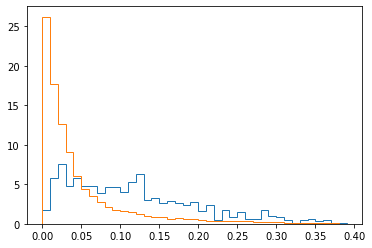

In [19]:
plt.hist(ri_probs[ri_events > 0], bins=np.arange(0, 0.4, 0.01), histtype="step", density=True)
plt.hist(ri_probs[ri_events == 0], bins=np.arange(0, 0.4, 0.01), histtype="step", density=True)

(array([1.54469160e-04, 0.00000000e+00, 0.00000000e+00, 3.08938320e-04,
        1.54469160e-04, 6.17876640e-04, 3.08938320e-04, 7.72345800e-04,
        9.26814959e-04, 4.63407480e-04, 2.00809908e-03, 2.16256824e-03,
        3.86172900e-03, 4.47960564e-03, 6.48770472e-03, 8.34133463e-03,
        1.09673104e-02, 1.57558543e-02, 1.85362992e-02, 2.44061273e-02,
        3.13572395e-02, 3.67636601e-02, 4.95846003e-02, 6.45681088e-02,
        9.48440642e-02, 1.33306885e-01, 1.70533953e-01, 2.08533366e-01,
        2.55800929e-01, 2.82987501e-01, 3.10019604e-01, 3.10328542e-01,
        2.65532486e-01, 2.20890899e-01, 1.74859089e-01, 1.45818887e-01,
        1.15079524e-01, 7.67711725e-02, 3.66091909e-02, 2.62597572e-03]),
 array([-13.55075211, -13.22686857, -12.90298504, -12.5791015 ,
        -12.25521796, -11.93133442, -11.60745088, -11.28356735,
        -10.95968381, -10.63580027, -10.31191673,  -9.98803319,
         -9.66414966,  -9.34026612,  -9.01638258,  -8.69249904,
         -8.3686155 , 

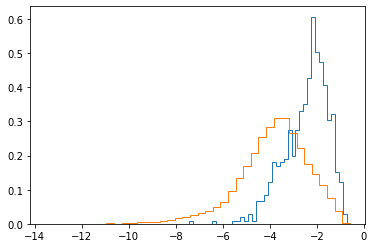

In [20]:
plt.hist(np.log(ri_probs[ri_events > 0]), bins=40, histtype="step", density=True)
plt.hist(np.log(ri_probs[ri_events == 0]), bins=40, histtype="step", density=True)

In [21]:
storm_runs = predictions[d_mode][model_name][predictions[d_mode][model_name]["STNAM"] == "laura"].run.unique()
print(storm_runs)

[474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499]


Index(['dense_base_discrete_-40', 'dense_base_discrete_-35',
       'dense_base_discrete_-30', 'dense_base_discrete_-25',
       'dense_base_discrete_-20', 'dense_base_discrete_-15',
       'dense_base_discrete_-10', 'dense_base_discrete_-5',
       'dense_base_discrete_00', 'dense_base_discrete_05',
       'dense_base_discrete_10', 'dense_base_discrete_15',
       'dense_base_discrete_20', 'dense_base_discrete_25',
       'dense_base_discrete_30', 'dense_base_discrete_35',
       'dense_base_discrete_40'],
      dtype='object')


<ipython-input-15-72cbc4cb95aa>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(f_hour, np.arange(-40, 50, 5), np.ma.array(preds, mask=preds<1e-2), vmin=0, vmax=0.3,


Index(['dense_focal_discrete_-40', 'dense_focal_discrete_-35',
       'dense_focal_discrete_-30', 'dense_focal_discrete_-25',
       'dense_focal_discrete_-20', 'dense_focal_discrete_-15',
       'dense_focal_discrete_-10', 'dense_focal_discrete_-5',
       'dense_focal_discrete_00', 'dense_focal_discrete_05',
       'dense_focal_discrete_10', 'dense_focal_discrete_15',
       'dense_focal_discrete_20', 'dense_focal_discrete_25',
       'dense_focal_discrete_30', 'dense_focal_discrete_35',
       'dense_focal_discrete_40'],
      dtype='object')


<ipython-input-15-72cbc4cb95aa>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(f_hour, np.arange(-40, 50, 5), np.ma.array(preds, mask=preds<1e-2), vmin=0, vmax=0.3,


Index(['conv_base_discrete_-40', 'conv_base_discrete_-35',
       'conv_base_discrete_-30', 'conv_base_discrete_-25',
       'conv_base_discrete_-20', 'conv_base_discrete_-15',
       'conv_base_discrete_-10', 'conv_base_discrete_-5',
       'conv_base_discrete_00', 'conv_base_discrete_05',
       'conv_base_discrete_10', 'conv_base_discrete_15',
       'conv_base_discrete_20', 'conv_base_discrete_25',
       'conv_base_discrete_30', 'conv_base_discrete_35',
       'conv_base_discrete_40'],
      dtype='object')


<ipython-input-15-72cbc4cb95aa>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(f_hour, np.arange(-40, 50, 5), np.ma.array(preds, mask=preds<1e-2), vmin=0, vmax=0.3,


Index(['conv_focal_discrete_-40', 'conv_focal_discrete_-35',
       'conv_focal_discrete_-30', 'conv_focal_discrete_-25',
       'conv_focal_discrete_-20', 'conv_focal_discrete_-15',
       'conv_focal_discrete_-10', 'conv_focal_discrete_-5',
       'conv_focal_discrete_00', 'conv_focal_discrete_05',
       'conv_focal_discrete_10', 'conv_focal_discrete_15',
       'conv_focal_discrete_20', 'conv_focal_discrete_25',
       'conv_focal_discrete_30', 'conv_focal_discrete_35',
       'conv_focal_discrete_40'],
      dtype='object')


<ipython-input-15-72cbc4cb95aa>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(f_hour, np.arange(-40, 50, 5), np.ma.array(preds, mask=preds<1e-2), vmin=0, vmax=0.3,


Index(['resnet_base_discrete_-40', 'resnet_base_discrete_-35',
       'resnet_base_discrete_-30', 'resnet_base_discrete_-25',
       'resnet_base_discrete_-20', 'resnet_base_discrete_-15',
       'resnet_base_discrete_-10', 'resnet_base_discrete_-5',
       'resnet_base_discrete_00', 'resnet_base_discrete_05',
       'resnet_base_discrete_10', 'resnet_base_discrete_15',
       'resnet_base_discrete_20', 'resnet_base_discrete_25',
       'resnet_base_discrete_30', 'resnet_base_discrete_35',
       'resnet_base_discrete_40'],
      dtype='object')


<ipython-input-15-72cbc4cb95aa>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(f_hour, np.arange(-40, 50, 5), np.ma.array(preds, mask=preds<1e-2), vmin=0, vmax=0.3,


Index(['resnet_focal_discrete_-40', 'resnet_focal_discrete_-35',
       'resnet_focal_discrete_-30', 'resnet_focal_discrete_-25',
       'resnet_focal_discrete_-20', 'resnet_focal_discrete_-15',
       'resnet_focal_discrete_-10', 'resnet_focal_discrete_-5',
       'resnet_focal_discrete_00', 'resnet_focal_discrete_05',
       'resnet_focal_discrete_10', 'resnet_focal_discrete_15',
       'resnet_focal_discrete_20', 'resnet_focal_discrete_25',
       'resnet_focal_discrete_30', 'resnet_focal_discrete_35',
       'resnet_focal_discrete_40'],
      dtype='object')


<ipython-input-15-72cbc4cb95aa>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(f_hour, np.arange(-40, 50, 5), np.ma.array(preds, mask=preds<1e-2), vmin=0, vmax=0.3,


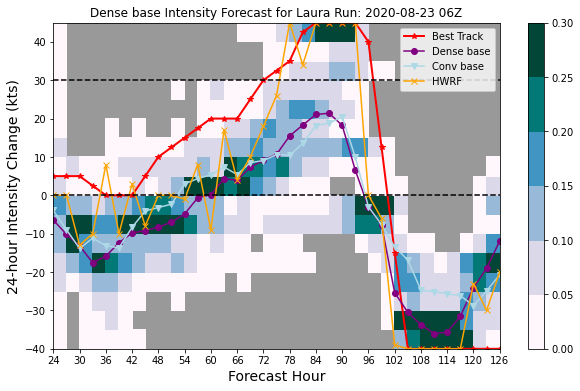

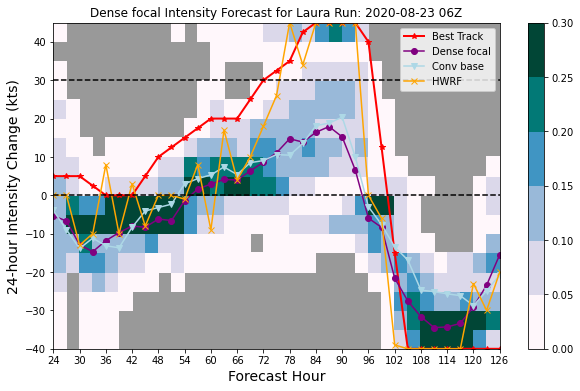

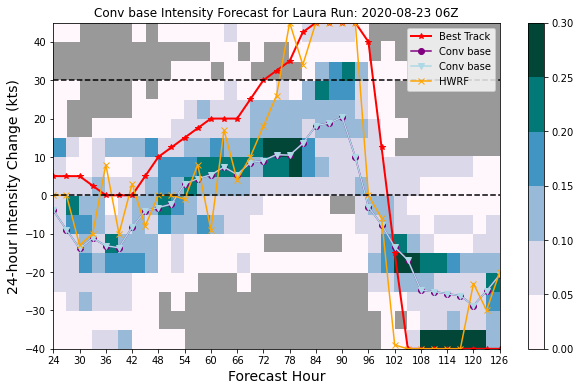

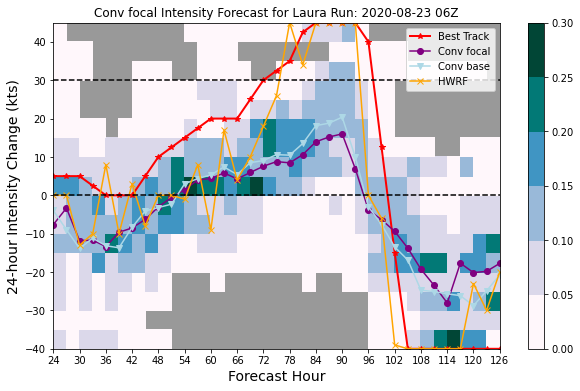

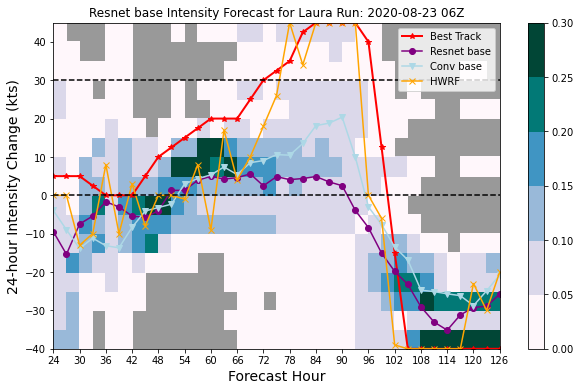

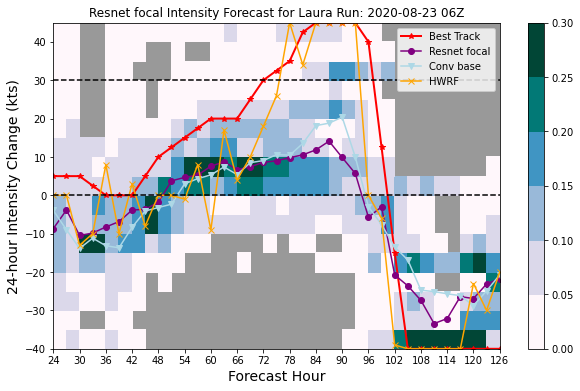

In [15]:
def constrain(x):
    return np.minimum(np.maximum(x, -40), 45)
model_name = "conv_focal_discrete"
d_mode = "test"

run_id = 481
for model_name in ["dense_base_discrete", "dense_focal_discrete", 
                   "conv_base_discrete", "conv_focal_discrete", "resnet_base_discrete", "resnet_focal_discrete"]:
    idx = predictions[d_mode][model_name].run == run_id
    fancy_model_name = " ".join(model_name.split("_")[:-1]).capitalize()
    all_columns = predictions[d_mode][model_name][idx].columns
    pred_columns = all_columns[all_columns.str.contains(model_name + "_")][::-1]
    print(pred_columns)
    intensity_bins = pred_columns.str.split("_").str[-1].values.astype(int)
    f_hour = predictions[d_mode][model_name][idx]["TIME"]
    preds = predictions[d_mode][model_name][idx][pred_columns].T.values
    fig = plt.figure(figsize=(10, 6))
    plt.pcolormesh(f_hour, np.arange(-40, 50, 5), np.ma.array(preds, mask=preds<1e-2), vmin=0, vmax=0.3, 
                   cmap=plt.get_cmap("PuBuGn", 6), rasterized=True)
    plt.plot(f_hour, constrain(predictions[d_mode][model_name][idx]["vmax_bt_dt_24"]), 'r*-', 
             lw=2, label="Best Track")
    plt.plot(f_hour, constrain(predictions[d_mode][model_name][idx][model_name]), 
             color="purple", marker='o', lw=1.5, label=f"{fancy_model_name}")
    plt.plot(f_hour, constrain(predictions[d_mode]["conv_base_discrete"][idx]["conv_base_discrete"]), 
             color='lightblue', marker='v', lw=1.5, label="Conv base")

    #plt.plot(f_hour, constrain(predictions[d_mode]["random_forest_linear"][idx]["random_forest_linear"]), 
    #         'go-', label="Random Forest")
    plt.plot(best_track_df[d_mode].loc[run_id]["TIME"], 
             constrain(best_track_df[d_mode].loc[run_id]["VMAX_dt_24"]), 
             color="orange", marker='x', label="HWRF")
    plt.gca().set_facecolor("0.6")
    plt.xticks(np.arange(f_hour.min(), f_hour.max() + 6, 6))
    plt.yticks(np.arange(-40, 50, 10))
    plt.ylabel("24-hour Intensity Change (kts)", fontsize=14)
    plt.xlabel("Forecast Hour", fontsize=14)
    plt.legend(loc="upper right")
    plt.plot(f_hour, np.ones(f_hour.shape) * 30, 'k--')
    plt.plot(f_hour, np.ones(f_hour.shape) * 0, 'k--')

    storm_name = predictions[d_mode][model_name][idx]["STNAM"].iloc[0].capitalize()
    run_date_str = str(predictions[d_mode][model_name][idx]["DATE"].iloc[0])
    init_date = pd.Timestamp( run_date_str + "00" ).strftime("%Y-%m-%d %HZ")

    plt.title(f"{fancy_model_name} Intensity Forecast for {storm_name} Run: {init_date}", fontsize=12)
    plt.colorbar()
    plt.savefig(join(out_path, "plots", f"ts_example_{model_name}_{year}_{storm_name}_{run_date_str}.pdf"), 
                bbox_inches="tight")
    plt.savefig(join(out_path, "plots", f"ts_example_{model_name}_{year}_{storm_name}_{run_date_str}.png"), 
                bbox_inches="tight", dpi=200)

In [40]:
dr_objs = []
droc_objs = []
model_names = list(predictions[d_mode].keys())
model_names = ['dense_base_discrete',
                'conv_base_discrete',
               ]
thresholds = np.array([0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
for model in model_names:
    all_columns = predictions[d_mode][model].columns
    pred_columns = all_columns[all_columns.str.contains(model + "_")][::-1]
    idxs = (predictions["test"][model]["BASIN"] == "l") & (predictions["test"][model]["TIME"] >=48)
    preds = predictions[d_mode][model].loc[idxs, pred_columns].T.values
    truth = np.where(predictions[d_mode][model].loc[idxs, "vmax_bt_dt_24"].values >= 30, 1, 0)
    dr_objs.append(DistributedReliability(thresholds=thresholds))
    dr_objs[-1].update(preds[-3:].sum(axis=0), truth)
    droc_objs.append(DistributedROC(thresholds=thresholds))
    droc_objs[-1].update(preds[-3:].sum(axis=0), truth)

In [23]:
long_model_names

['Dense base', 'Conv base']

In [28]:
hwrf_preds = best_track_df[d_mode].loc[(best_track_df[d_mode]["BASIN"] == "l") & (best_track_df[d_mode]["TIME"] >= 48)]["VMAX_dt_24"].values

In [37]:
idxs.shape

(20615,)

In [41]:
droc_objs.append(DistributedROC(thresholds=np.arange(-40, 65, 5)))
droc_objs[-1].update(hwrf_preds, truth)

In [20]:
long_model_names = [" ".join(x.split("_")[:-1]).capitalize() for x in model_names]
model_names_bss = []
model_names_perf = []
for i in range(len(long_model_names)):
    bss_m = dr_objs[i].brier_skill_score()
    csi_m = droc_objs[i].max_csi()
    model_names_bss.append(long_model_names[i] + f" ({bss_m:0.3f})")
    model_names_perf.append(long_model_names[i] + f" ({csi_m:0.3f})")

In [42]:
def performance_diagram(roc_objs, obj_labels, colors, markers, filename, figsize=(8, 8),
                        xlabel="Success Ratio (1-FAR)",
                        ylabel="Probability of Detection", ticks=np.arange(0, 1.1, 0.1),
                        dpi=300, csi_cmap="Blues",
                        csi_label="Critical Success Index", title="Performance Diagram",
                        legend_params=None, bootstrap_sets=None, ci=(2.5, 97.5)):
    """
    Draws a performance diagram from a set of DistributedROC objects.

    A performance diagram is a variation on the ROC curve in which the Probability of False Detection on the
    x-axis has been replaced with the Success Ratio (1-False Alarm Ratio or Precision). The diagram also shows
    the Critical Success Index (CSI or Threat Score) as a series of curved contours, and the frequency bias as
    angled diagonal lines. Points along the 1:1 diagonal are unbiased, and better performing models should appear
    in the upper right corner. The performance diagram is particularly useful for displaying verification for
    severe weather warnings as it displays all three commonly used statistics (POD, FAR, and CSI) simultaneously
    on the same chart.

    Args:
        roc_objs (list): DistributedROC objects being plotted.
        obj_labels: list or array of labels describing each DistributedROC object.
        obj_labels (list): Label describing the forecast associated with a DistributedROC object.
        colors (list): List of matplotlib-readable colors (names or hex-values) for each curve.
        markers (list): Matplotlib marker (e.g. *, o, v, etc.) for each curve.
        filename (str): Name of figure file being saved.
        figsize (tuple): (Width, height) of the figure in inches.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): The title of the figure.
        ticks (numpy.ndarray): Values shown on the x and y axes.
        dpi (int): Figure resolution in dots per inch.
        csi_cmap (str): Matplotlib colormap used to fill CSI contours.
        csi_label (str): Label for CSI colormap.
        legend_params (None or dict): Keyword arguments for the formatting of the figure legend.
        bootstrap_sets (list): A list of arrays of bootstrapped DistributedROC objects. If not None,
            confidence regions will be plotted.
        ci (tuple): tuple of bootstrap confidence interval percentiles

    Examples:

        >>> from hagelslag.evaluation import DistributedROC
        >>> import numpy as np
        >>> forecasts = np.random.random(1000)
        >>> obs = np.random.random_integers(0, 1, 1000)
        >>> roc = DistributedROC()
        >>> roc.update(forecasts, obs)
        >>> performance_diagram([roc], ["Random"], ["orange"], ["o"], "random_performance.png")
    """
    if legend_params is None:
        legend_params = dict(loc=0, fontsize=10, framealpha=1, frameon=True)
    plt.figure(figsize=figsize)
    grid_ticks = np.arange(0, 1.01, 0.01)
    sr_g, pod_g = np.meshgrid(grid_ticks, grid_ticks)
    bias = pod_g / sr_g
    csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)
    csi_contour = plt.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap=csi_cmap)
    b_contour = plt.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed")
    plt.clabel(b_contour, fmt="%1.1f", manual=[(0.2, 0.9), (0.4, 0.9), (0.6, 0.9), (0.7, 0.7), (0.9, 0.4)])
    if bootstrap_sets is not None:
        for b, b_set in enumerate(bootstrap_sets):
            perf_curves = np.dstack([b_roc.performance_curve().values for b_roc in b_set])
            pod_range = np.nanpercentile(perf_curves[:, 0], ci, axis=1)
            sr_range = np.nanpercentile(1 - perf_curves[:, 1], ci, axis=1)
            pod_poly = np.concatenate((pod_range[1], pod_range[0, ::-1]))
            sr_poly = np.concatenate((sr_range[1], sr_range[0, ::-1]))
            pod_poly[np.isnan(pod_poly)] = 0
            sr_poly[np.isnan(sr_poly)] = 1
            plt.fill(sr_poly, pod_poly, alpha=0.5, color=colors[b])
    for r, roc_obj in enumerate(roc_objs):
        perf_data = roc_obj.performance_curve()
        plt.plot(1 - perf_data["FAR"], perf_data["POD"], marker=markers[r], color=colors[r], 
                 ms=8, label=obj_labels[r])
        for t, threshold in enumerate(perf_data["Thresholds"]):
            if ~np.isnan(perf_data.loc[t, "FAR"]) and ~np.isnan(perf_data.loc[t, "POD"]):
                if abs(threshold) <= 1:
                    thresh_int = int(threshold * 100)
                else:
                    thresh_int = int(threshold)
                plt.text(1-perf_data.loc[t, "FAR"], perf_data.loc[t, "POD"], "{0:d}".format(thresh_int),
                     color='white', ha='center', va='center', fontsize=6)
    cbar = plt.colorbar(csi_contour)
    cbar.set_label(csi_label)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(ticks, fontsize=14)
    plt.yticks(ticks, fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(**legend_params)
    plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    plt.close()

In [36]:
attributes_diagram(dr_objs, model_names_bss, ["red", "pink", "blue", "skyblue", "purple", "violet"], 
                   ["o",'o',"+", "+", "v", "v"], join(out_path, "plots", f"ri_attributes.pdf"), 
                   title="2020 Atlantic RI Reliability", legend_params={"loc": "upper right", "fontsize":12})

In [26]:
out_path

'/glade/scratch/dgagne/hwrf_2020_rt_output_20210128/'

In [44]:
performance_diagram(droc_objs, model_names_perf + ["HWRF"], ["purple", 'red', "blue"], 
                   ["o", '^', "v"], join(out_path, "plots", f"ri_performance.pdf"),
                    title="2020 Atlantic RI Performance")

<ipython-input-42-636dfc17b8aa>:53: RuntimeWarning: divide by zero encountered in true_divide
  bias = pod_g / sr_g
<ipython-input-42-636dfc17b8aa>:53: RuntimeWarning: invalid value encountered in true_divide
  bias = pod_g / sr_g
<ipython-input-42-636dfc17b8aa>:54: RuntimeWarning: divide by zero encountered in true_divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


In [52]:
roc_curve(droc_objs, model_names_perf + ["HWRF"], ["red", 'pink', "blue", "skyblue", "purple", "violet", "green", "k"], 
                   ["o", 'o', "+", "+", "v", "v", "^", "v"], join(out_path, "plots", f"ri_roc.pdf"),
                    title="2020 Atlantic RI Performance")

In [51]:
droc_objs[0].auc()

0.8561070313159449

In [67]:
[d.brier_skill_score() for d in dr_objs]

[0.12312074899509257,
 0.0646384465227314,
 0.07352325488000493,
 -0.03632256809392837,
 0.04575703894253908,
 0.0634498430278419]

In [68]:
[d.auc() for d in droc_objs]

[0.8633918077037642,
 0.7877362957942393,
 0.7995726150186013,
 0.7281471422444684,
 0.7587223786020055,
 0.8023954777071295]

In [117]:
model_names

['random_forest_linear',
 'dense_neural_net_discrete',
 'conv_linear',
 'resnet_linear',
 'conv_discrete',
 'conv_focal_discrete',
 'conv_rps_discrete',
 'conv_mixed',
 'resnet_discrete']

In [363]:
best_track_df["test"]["STNAM"].unique()

array(['invest', 'one', 'alvin', 'barbara', 'six', 'erick', 'seven',
       'flossie', 'juliette', 'twelve', 'thirteen', 'kiko', 'fourteen',
       'mario', 'lorena', 'sixteen', 'narda', 'eighteen', 'octave',
       'twenty', 'raymond', 'andrea', 'two', 'barry', 'chantal', 'five',
       'dorian', 'eight', 'gabrielle', 'nine', 'humberto', 'ten', 'jerry',
       'karen', 'lorenzo', 'melissa', 'fifteen', 'nestor', 'olga',
       'pablo', 'rebekah', 'sebastien', 'four', 'francisco', 'lekima',
       'eleven', 'krosa', 'podul', 'faxai', 'hagibis', 'neoguri',
       'bualoi', 'matmo', 'halong', 'fengshen', 'kalmaegi', 'kammuri'],
      dtype=object)

In [340]:
best_track_df[mode].loc[run_id].columns

Index(['DATE', 'STNAM', 'STNUM', 'BASIN', 'TIME', 'LON', 'LAT', 'STM_SPD',
       'STM_HDG', 'LAND', 'RMW_dt_24', 'VMAX_dt_24', 'MIN_SLP_dt_24',
       'SHR_MAG_dt_24', 'SST_dt_24', 'LAND_dt_24', 'TPW_dt_24',
       'TANG850_dt_24', 'VORT850_dt_24', 'DVRG200_dt_24', 'STM_SPD_dt_24',
       'RHLO_dt_24', 'RHMD_dt_24', 'RHHI_dt_24', 'INST1_dt_24', 'INST2_dt_24',
       'vmax_bt_dt_24'],
      dtype='object')

In [281]:
preds.sum(axis=0)

array([1.00000005, 1.        , 1.00000003, 1.0000001 , 1.00000003,
       1.00000008, 0.99999996, 0.99999994, 1.00000004, 0.99999999,
       1.00000003, 1.00000004, 1.00000002, 0.99999999, 1.        ,
       1.00000003, 1.00000003, 0.99999991, 0.99999991, 0.99999999,
       1.00000013, 1.00000006, 0.99999999, 1.00000005, 0.99999992,
       1.00000001, 1.00000001, 0.99999998, 1.00000001, 0.99999996,
       1.        , 0.99999989, 1.00000003, 1.00000008, 1.00000012])

In [32]:
predictions[d_mode][model_name][idx]

,run,time,DATE,STNAM,STNUM,BASIN,TIME,LON,LAT,STM_SPD,...,resnet_focal_discrete_-5,resnet_focal_discrete_-10,resnet_focal_discrete_-15,resnet_focal_discrete_-20,resnet_focal_discrete_-25,resnet_focal_discrete_-30,resnet_focal_discrete_-35,resnet_focal_discrete_-40,vmax_bt_dt_24,resnet_focal_discrete
7116,481,8,2020082306,laura,13,l,24,282.3,21.1,19.588037,...,0.106923,0.120088,0.146465,0.112872,0.078373,0.059411,0.025792,0.040045,5.0,-8.663198
7117,481,9,2020082306,laura,13,l,27,281.3,21.5,20.255138,...,0.080119,0.069088,0.095781,0.080530,0.041473,0.055629,0.044733,0.069064,5.0,-3.825318
7118,481,10,2020082306,laura,13,l,30,280.3,21.9,19.839193,...,0.079909,0.097888,0.412144,0.112597,0.034866,0.015675,0.002656,0.021905,5.0,-10.470446
7119,481,11,2020082306,laura,13,l,33,279.3,22.2,17.150387,...,0.167477,0.147115,0.325263,0.111788,0.026485,0.011161,0.001185,0.013709,2.5,-9.833168
7120,481,12,2020082306,laura,13,l,36,278.5,22.3,12.391927,...,0.105471,0.122487,0.105468,0.094952,0.090655,0.055629,0.037957,0.065902,0.0,-8.248702
7121,481,13,2020082306,laura,13,l,39,278.0,22.5,13.101414,...,0.127492,0.132961,0.169385,0.072941,0.063193,0.038122,0.015719,0.042252,0.0,-6.861602
7122,481,14,2020082306,laura,13,l,42,277.3,23.0,18.057210,...,0.163966,0.165735,0.176017,0.037182,0.036445,0.014505,0.003444,0.012823,0.0,-3.848547
7123,481,15,2020082306,laura,13,l,45,276.3,23.4,19.617058,...,0.275610,0.296396,0.070273,0.018495,0.005450,0.001924,0.000627,0.006675,5.0,-3.640032
7124,481,16,2020082306,laura,13,l,48,275.4,23.9,17.965109,...,0.191590,0.151759,0.116475,0.019481,0.010514,0.009179,0.002684,0.009924,10.0,-1.802666
7125,481,17,2020082306,laura,13,l,51,274.6,24.3,14.939605,...,0.108807,0.141956,0.043821,0.011614,0.005470,0.007679,0.001922,0.009837,12.5,3.770505


In [148]:
all_columns[all_columns.str.contains(model_name + "_")][::-1].size

17

In [153]:
pred_columns.str.split("_").str[1]

Index(['discrete', 'discrete', 'discrete', 'discrete', 'discrete', 'discrete',
       'discrete', 'discrete', 'discrete', 'discrete', 'discrete', 'discrete',
       'discrete', 'discrete', 'discrete', 'discrete', 'discrete'],
      dtype='object')